In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
image_dir = "/content/drive/MyDrive/model/Product_detection/image-product"

In [ ]:
import pathlib
batik_dir = pathlib.Path(image_dir).with_suffix('')
image_count = len(list(batik_dir.glob('*/*.jpg')))
print(image_count)

141


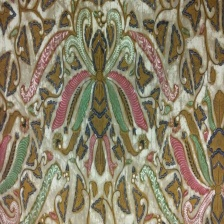

In [ ]:
bali = list(data_dir.glob('Bali/*'))
PIL.Image.open(str(bali[0]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  batik_dir,
  training_split=0.8,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 141 files belonging to 14 classes.
Using 113 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  batik_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 141 files belonging to 14 classes.
Using 28 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bali', 'Betawi', 'Cendrawasih', 'Dayak', 'Geblek_Renteng', 'Insang', 'Kawung', 'Lasem', 'Megamendung', 'Pala', 'Parang', 'Poleng', 'Sekar_Jagad', 'Tambal']


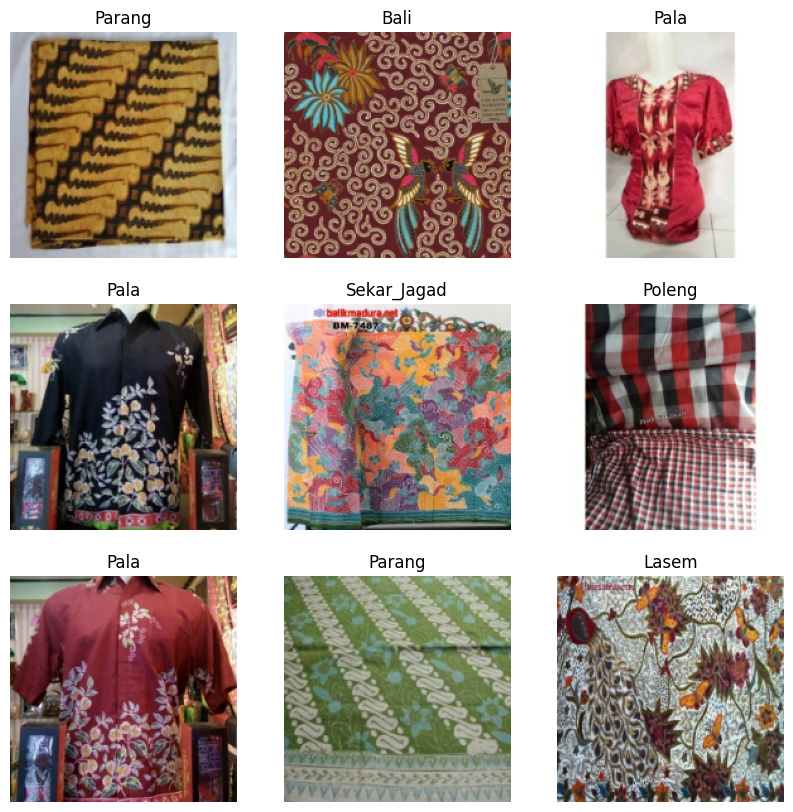

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.059303366 0.9950893


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.trainable = False

model = tf.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)      

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 9s 2s/step - loss: 3.3127 - accuracy: 0.0265 - val_loss: 2.8734 - val_accuracy: 0.0714
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 2.6889 - accuracy: 0.1150 - val_loss: 2.6264 - val_accuracy: 0.0357
Epoch 3/10
4/4 [==============================] - 5s 1s/step - loss: 2.5586 - accuracy: 0.2832 - val_loss: 2.6217 - val_accuracy: 0.1071
Epoch 4/10
4/4 [==============================] - 4s 974ms/step - loss: 2.4038 - accuracy: 0.3363 - val_loss: 2.5997 - val_accuracy: 0.1071
Epoch 5/10
4/4 [==============================] - 4s 837ms/step - loss: 2.0760 - accuracy: 0.4336 - val_loss: 2.5519 - val_accuracy: 0.3214
Epoch 6/10
4/4 [==============================] - 8s 2s/step - loss: 1.6138 - accuracy: 0.6283 - val_loss: 2.5435 - val_accuracy: 0.3214
Epoch 7/10
4/4 [==============================] - 6s 1s/step - loss: 1.1160 - accuracy: 0.7257 - val_loss: 2.7921 - val_accuracy: 0.2500
Epoch 8/10
4/4 [===================

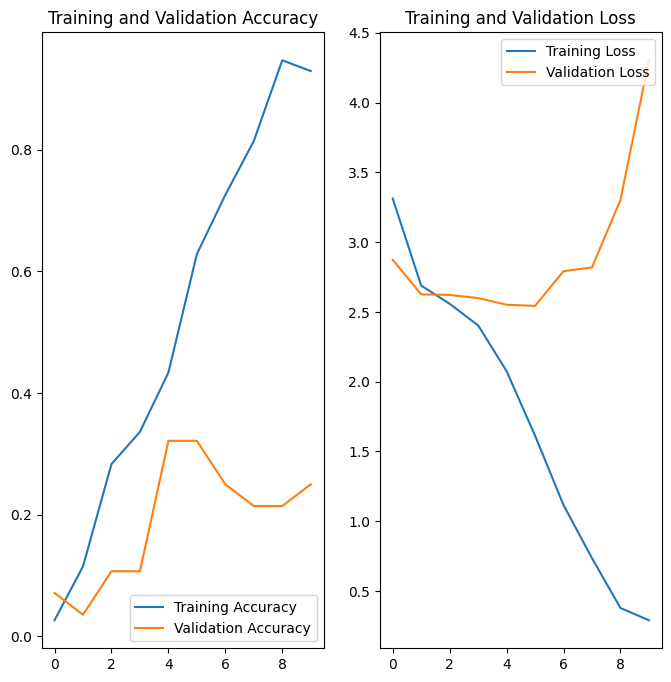

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

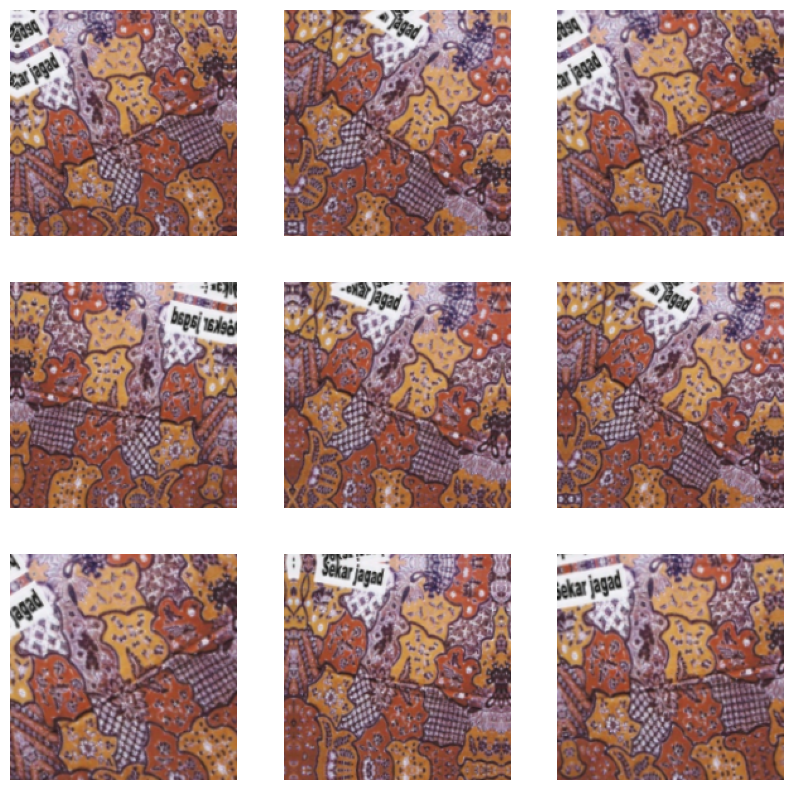

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
4/4 [==============================] - 5s 993ms/step - loss: 1.1886 - accuracy: 0.6195 - val_loss: 3.8643 - val_accuracy: 0.2500
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 1.1003 - accuracy: 0.6726 - val_loss: 4.8672 - val_accuracy: 0.1786
Epoch 3/100
4/4 [==============================] - 4s 978ms/step - loss: 0.8829 - accuracy: 0.7345 - val_loss: 4.4904 - val_accuracy: 0.2143
Epoch 4/100
4/4 [==============================] - 4s 1s/step - loss: 0.8744 - accuracy: 0.7345 - val_loss: 4.9720 - val_accuracy: 0.2500
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.8580 - accuracy: 0.7168 - val_loss: 4.7597 - val_accuracy: 0.2500
Epoch 6/100
4/4 [==============================] - 6s 1s/step - loss: 0.7884 - accuracy: 0.7522 - val_loss: 6.0747 - val_accuracy: 0.1786
Epoch 7/100
4/4 [==============================] - 4s 985ms/step - loss: 0.6830 - accuracy: 0.8053 - val_loss: 5.3671 - val_accuracy: 0.2143
Epoch 8/100
4/4 [========

<h1> SAVE MODEL

In [ ]:
# model.save('/content/drive/MyDrive/model/Product_detection/verifikasi_batik.h5')

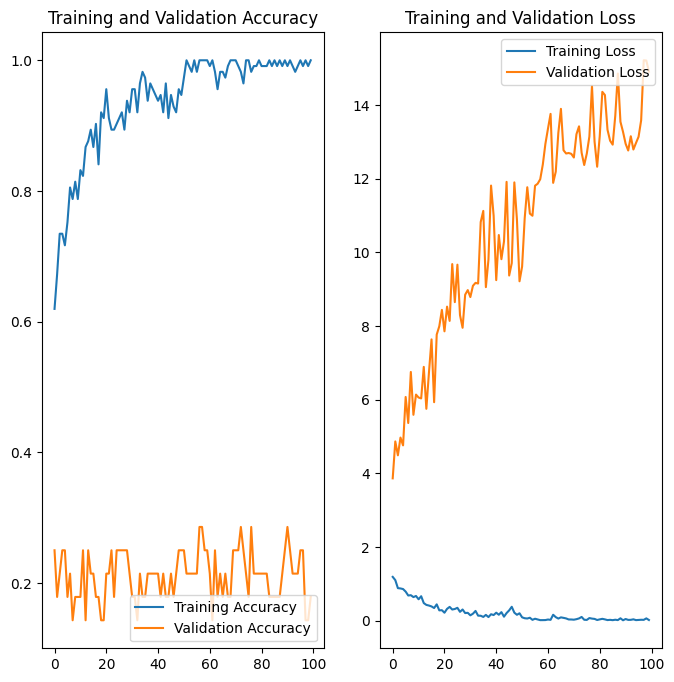

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/model/Product_detection/verifikasi_batik.h5"
model_verif = tf.keras.models.load_model(model_path)

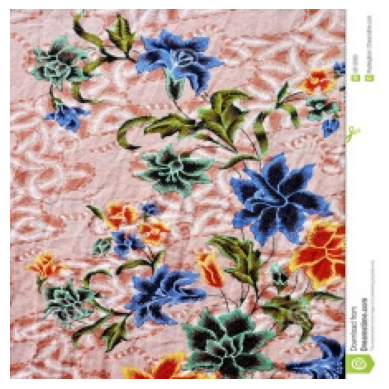

In [230]:
import matplotlib.image as mpimg

def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

image_path = "/content/drive/MyDrive/model/Product_detection/image-product/Bali/5.jpg"
show_image(image_path)

In [231]:
# Memuat gambar dari file lokal
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)

# Memasukkan gambar ke array numpy
img_array = tf.keras.utils.img_to_array(img)

# Menambahkan dimensi batch ke array
img_array = tf.expand_dims(img_array, 0) # Create a batch

# Memprediksi kelas gambar
predictions = model_verif.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 154ms/step
This image most likely belongs to Bali with a 89.27 percent confidence.
